In [1]:
import os
from pathlib import Path
import requests
from tqdm import tqdm
from typing import Union, List

import math
import torch
import numpy as np
import audiotools
import dasp_pytorch
import auraloss
import laion_clap
from audiotools import AudioSignal

from transformers import BertForMaskedLM


import matplotlib.pyplot as plt
%matplotlib inline

NOTEBOOKS_DIR = Path(os.path.abspath(''))
PROJECT_DIR = NOTEBOOKS_DIR.parent
ASSETS_DIR = PROJECT_DIR / "assets"
PRETRAINED_DIR = PROJECT_DIR / "pretrained"
DATA_DIR = PROJECT_DIR / "data"

In [2]:
# Load audio examples
exts = ["mp3", "wav", "flac"]
example_files = [list(ASSETS_DIR.rglob(f"*.{e}")) for e in exts]
example_files = sum(example_files, [])  # Trick to flatten list of lists


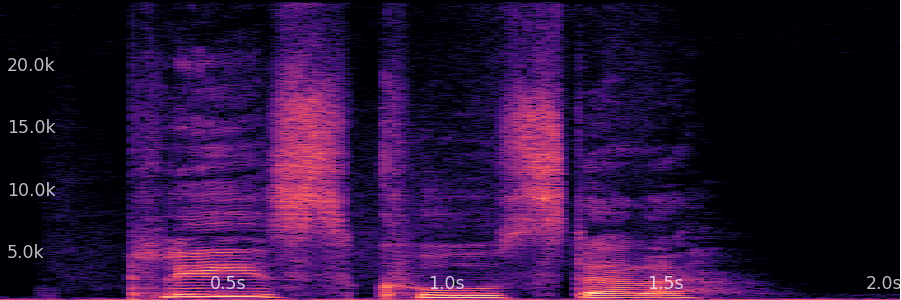
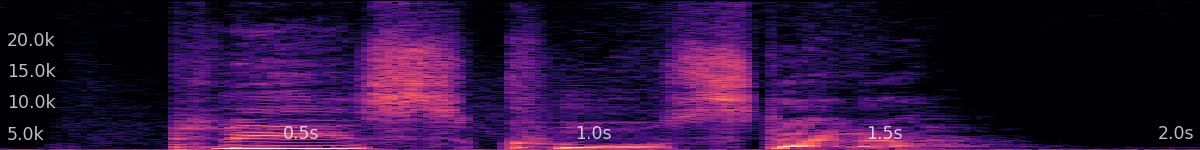

In [3]:
signal = AudioSignal(example_files[5])
signal.widget()

#### DASP set-up

In [4]:
#distortion rewrite bc of bug
class Distortion(dasp_pytorch.modules.Processor):
    def __init__(
        self,
        sample_rate: int = None,
        min_drive_db: float = 0.0,
        max_drive_db: float = 24.0,
    ):
        super().__init__()
        self.sample_rate = sample_rate
        self.process_fn = dasp_pytorch.functional.distortion
        self.param_ranges = {
            "drive_db": (min_drive_db, max_drive_db),
        }
        self.num_params = len(self.param_ranges)

In [5]:
#channel
from typing import Iterable


class Channel(torch.nn.Module):
    def __init__(self, *args):
    
        super().__init__()
    
        modules = []
        if isinstance(args[0], Iterable) and len(args) == 1:
            for m in args[0]:
                assert isinstance(m, dasp_pytorch.modules.Processor)
                modules.append(m)
        else:
            for m in args:
                assert isinstance(m, dasp_pytorch.modules.Processor)
                modules.append(m)

        # Ensure consistent sample rate
        sample_rates = [m.sample_rate for m in modules]

        # If not uniform, go with highest sample rate
        self.sample_rate = max(sample_rates)

        for i, m in enumerate(modules):
            modules[i].sample_rate = self.sample_rate
        self.modules = modules

    @property #AC what does this do? -- hacky thing decorator/annotator, concrete attribute, this is a getter
    def num_params(self):
        return sum([m.num_params for m in self.modules])

    #if you call the object, it automatically calls **forward()** (uses __call__)
    def forward(self, signal: AudioSignal, params: torch.Tensor):

        output = signal.clone().resample(self.sample_rate)
        
        # Check for valid shape
        assert params.ndim == 2  # (n_batch, n_parameters)
        assert params.shape[-1] == self.num_params

        params_count = 0
        for m in self.modules:

            # Select parameters corresponding to current effect module
            _params = params[:, params_count: params_count + m.num_params]
            params_count += m.num_params

            # Apply effect
            output.audio_data = m.process_normalized(output.audio_data, _params) #so assumes _params is normalized [0, 1]

            # Avoid clipping
            output.ensure_max_of_audio()
            
        return output.resample(signal.sample_rate)  # Restore original sample rate

In [6]:
# setting sample rate
SAMPLE_RATE = 44_100  # Resample all audio to a fixed rate, and pass to any effects that need it
# x = signal.resample(SAMPLE_RATE).audio_data  # (n_batch, n_channels, n_samples) <-- AC: don't need this right?



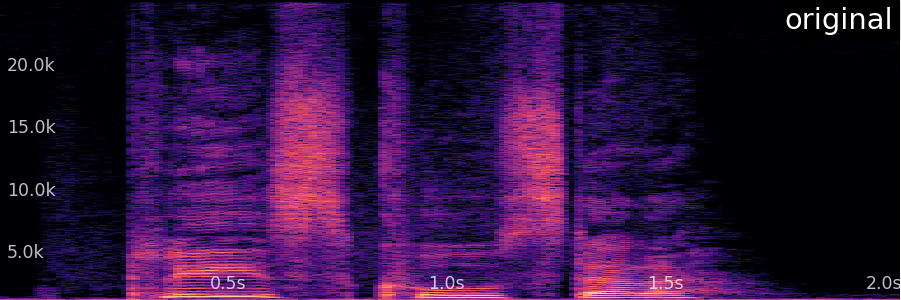
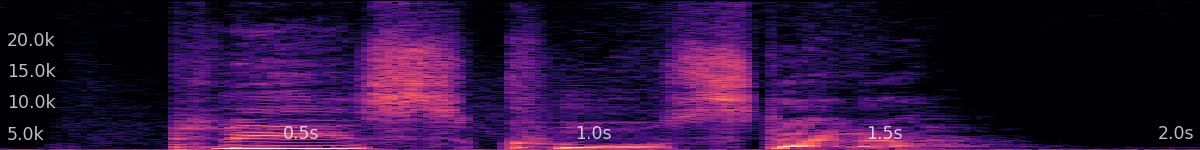

duration: 2.051 seconds
batch_size: 1
path: /home/annie/research/text2fx/assets/speech_examples/VCTK_p225_001_mic1.flac
sample_rate: 48000
num_channels: 2
audio_data.shape: torch.Size([1, 2, 98472])
stft_params: STFTParams(window_length=2048, hop_length=512, window_type='hann', match_stride=False, padding_type='reflect')
device: cuda:0




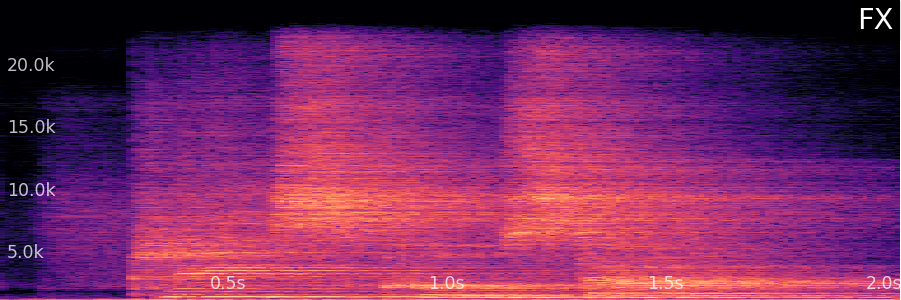
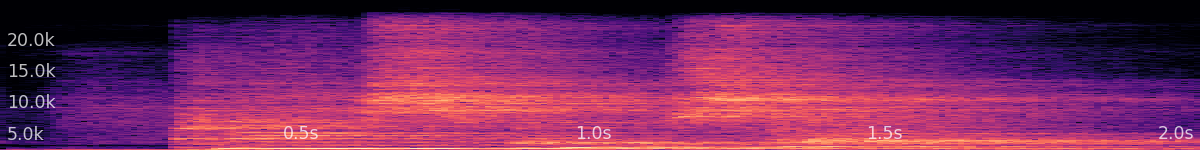

In [59]:
#quick example

channel = Channel(
    # Apply random EQ, Compression, and Gain to a signal
    dasp_pytorch.ParametricEQ(sample_rate=SAMPLE_RATE),
    dasp_pytorch.Compressor(sample_rate=SAMPLE_RATE),
    dasp_pytorch.Gain(sample_rate=SAMPLE_RATE),
    
    # Apply random Reverb and Distortion to a signal
    Distortion(sample_rate=SAMPLE_RATE),
    dasp_pytorch.NoiseShapedReverb(sample_rate=SAMPLE_RATE),
)

# Let's try to speed up our effects by running on GPU
if torch.cuda.is_available():
    params = torch.randn(signal.batch_size, channel.num_params)
    params_norm = torch.sigmoid(params)
    
    params_norm_cuda = params_norm.clone().cuda()
    signal_cuda = signal.clone().cuda()
    signal.clone().widget('original')
    # signal_cuda.cpu().widget(title='original')
    
    output_cuda = channel(signal_cuda, params_norm_cuda)
    print(output_cuda) 
    output_cuda.cpu().widget(title = 'FX')

else:
    print("CUDA not available on this machine; you'll have to use CPU :(")

Target audio (we want output to sound like this)



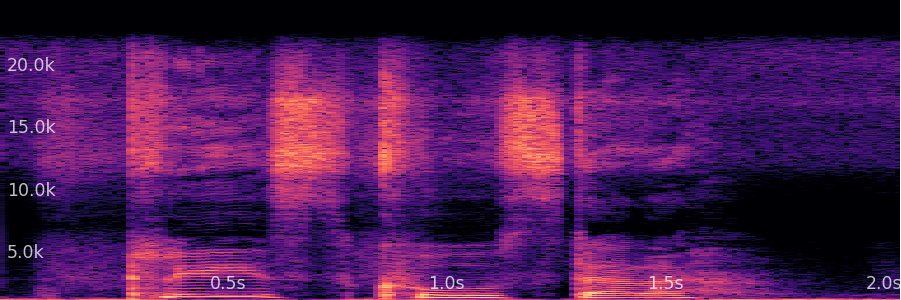
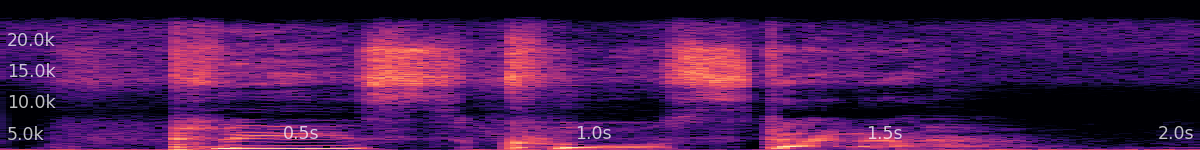

Starting audio -- untrained params, first stage



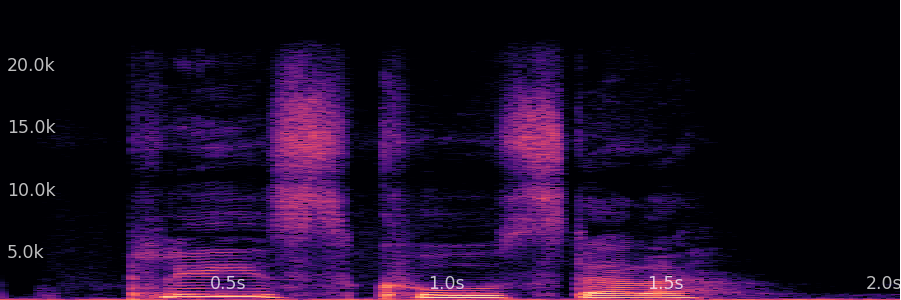
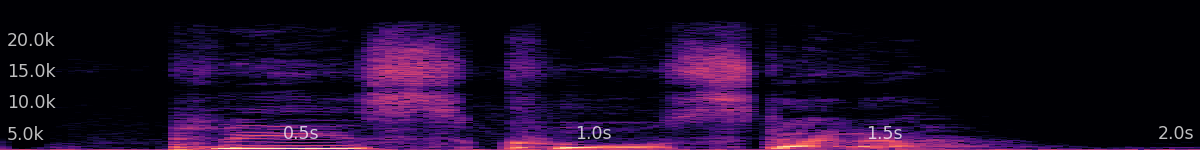

step: 500/500, loss: 0.029: 100%|████████████| 500/500 [00:32<00:00, 15.41it/s]


Final audio



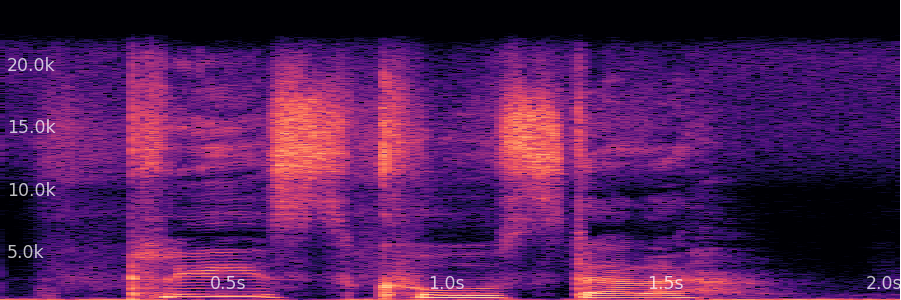
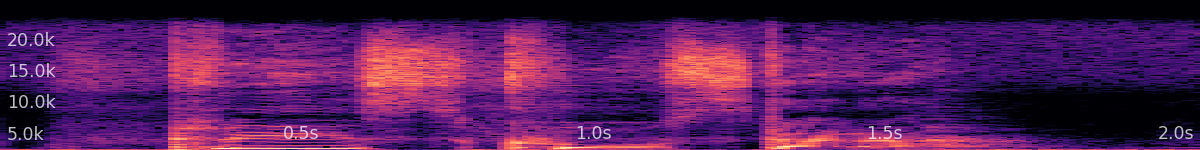

In [8]:
# example parameter extraction
channel = Channel(
    dasp_pytorch.ParametricEQ(sample_rate=SAMPLE_RATE),
    dasp_pytorch.Compressor(sample_rate=SAMPLE_RATE),
)

# Use GPU if available
device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
signal = signal.to(device)

# Initialize random parameters as a "target." Our goal will be to optimize a different set of
# random parameters to match these
params_target = torch.randn(signal.batch_size, channel.num_params).to(device) #roughly [-2, 2] 

# Apply target parameters to get target audio. We will optimize by matching this audio, without any access to
# the target parameters. This mimics the fact that in many real-world scenarios, we won't know the actual 
# target parameters, and will have to estimate them from audio

signal_target = channel(signal.clone().to(device), torch.sigmoid(params_target)).detach() 
#^ autograd -backprop engine, computation graph set of operations tracking gradients, don't track gradients for any of this
# don't often have to use it, but in some cases...

# Initialize our starting parameters
params = torch.nn.parameter.Parameter(torch.randn(signal.batch_size, channel.num_params).to(device))
optimizer = torch.optim.Adam([params], lr=1e-2)

# Play our target and starting audio
print("Target audio (we want output to sound like this)")
signal_target.clone().cpu().widget()
print("Starting audio -- untrained params, first stage")
channel(signal.clone().to(device), torch.sigmoid(params)).clone().detach().cpu().widget()

# Optimize our parameters by matching effected audio against the target audio -- AC QUESTION: CONTROLLER?
n_iters = 500
pbar = tqdm(range(n_iters), total=n_iters)
for n in pbar:
    
    # Apply effect with out estimated parameters
    signal_effected = channel(signal, torch.sigmoid(params))

    # Compute distance between estimate and target spectrograms as our loss; in practice,
    # we can use more complicated loss functions to get better results
    loss = torch.nn.functional.mse_loss( #L2
        signal_effected.magnitude, signal_target.magnitude 
        # .magnitude is a (real) property in audiosignal class and computes spectrogram (phase is imaginary component, don't really need it)
        # there are better resolutions/types of spectrograms -- maybe experiment here (e.g. christian -- auraloss)
    )
    # loss = auraloss(signal_effected=resampled.., signal_original=resampled..) <-- what using aura
    # try prem's ? 

    # Optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    pbar.set_description(f"step: {n+1}/{n_iters}, loss: {loss.item():.3f}")

# Play final signal with optimized effects parameters
print("Final audio")
channel(signal.clone().to(device), torch.sigmoid(params)).clone().detach().cpu().widget()
        

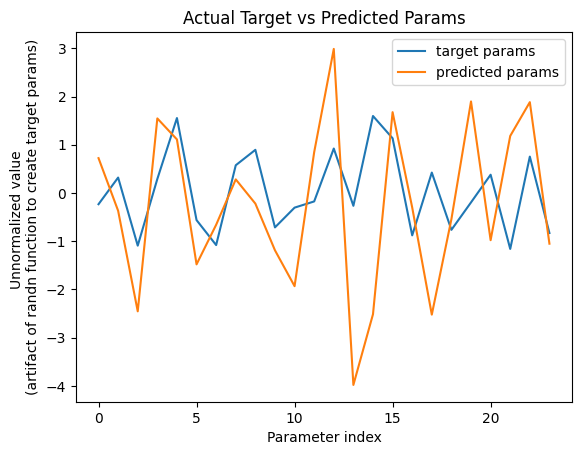

In [9]:
plt.plot(params_target.flatten().cpu().detach(), label="target params")
plt.plot(params.flatten().cpu().detach(), label="predicted params")
plt.ylabel("Unnormalized value \n(artifact of randn function to create target params)") #AC: why is the unnormalized range ~[-2.5, 2.5]? --> just random starting points
plt.xlabel("Parameter index")
plt.title("Actual Target vs Predicted Params")

plt.legend()
plt.show()

#### CLAP

Previously tried LAION edition of CLAP -- seems to not be very good / accurate

Trying new Microsoft CLAP

In [11]:
from msclap import CLAP
import torch.nn.functional as F

# Load model (Choose between versions '2022' or '2023')
# The model weight will be downloaded automatically if `model_fp` is not specified
clap_model = CLAP(version = '2023', use_cuda=True)

CLAP_weights_2023.pth:   0%|          | 0.00/690M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [39]:
clapcap_model = CLAP(version = 'clapcap', use_cuda=True)

clapcap_weights_2023.pth:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]


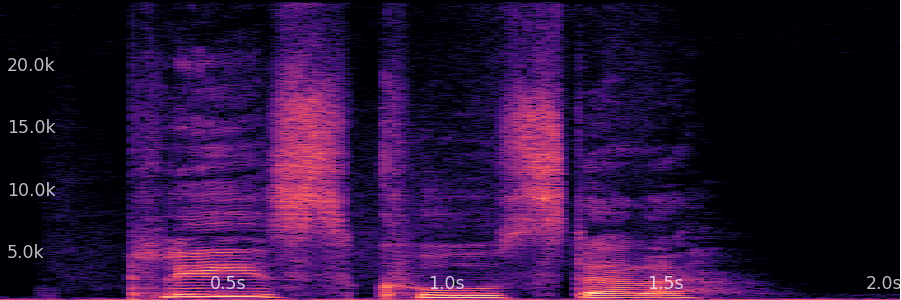
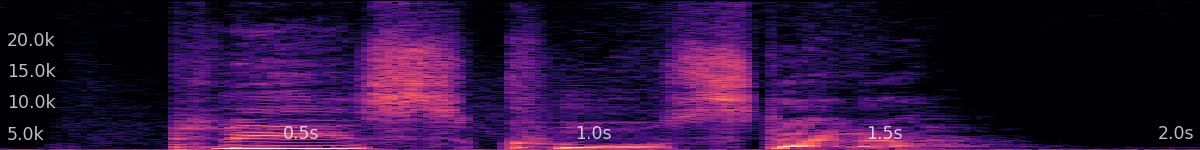

['A man speaks and then pauses. ']


In [49]:
# load audio file

file = example_files[5]
audio_file = [str(file)]

audiosig = AudioSignal(file)
audiosig.widget()

#generate caption
captions = clapcap_model.generate_caption(audio_file)
print(captions)

In [51]:
# Extract text embeddings
target_text = 'a woman talking'
_textOptions = [target_text, 'a man talking', 'a british person talking', 'a british woman talking', 'a dog', 'a cat', 'distorted version of a woman talking']

# Adding in the CLAP generated caption
#_textOptions = [captions[0], target_text, 'a man talking', 'a british person talking', 'a british woman talking', 'a dog', 'a cat', 'distorted version of a woman talking']

_prefix = '' #'this is a sound of ' #<-- they include this in their example, does skew zero-shot predictions
prompts = [_prefix + x for x in _textOptions]

# Load audio files
print(example_files[5])
audio_file = [str(example_files[5])]

text_embeddings = clap_model.get_text_embeddings(prompts)

# Extract audio embeddings
audio_embeddings = clap_model.get_audio_embeddings(audio_file, resample=True)

# Compute similarity between audio and text embeddings 
similarities = clap_model.compute_similarity(audio_embeddings, text_embeddings) #L2 normalized, then cosine similarity (dot prod)

similarity = F.softmax(similarities, dim=1)
values, indices = similarity[0].topk(5)

# Print the results
print("Ground Truth: {}".format(target_text))
print("Top predictions:\n")
for value, index in zip(values, indices):
    # print(f"{_textOptions[index]:>16s}: {100 * value.item():.2f}% ")
    print(f"{_textOptions[index]:<40s}: {100 * value.item():.2f}% (Similarity Score: {similarities[0][index].item():.4f})")


/home/annie/research/text2fx/assets/speech_examples/VCTK_p225_001_mic1.flac
Ground Truth: a woman talking
Top predictions:

a british woman talking                 : 61.41% (Similarity Score: 8.8991)
a british person talking                : 16.87% (Similarity Score: 7.6071)
a woman talking                         : 12.39% (Similarity Score: 7.2983)
distorted version of a woman talking    : 7.40% (Similarity Score: 6.7836)
a man talking                           : 1.93% (Similarity Score: 5.4372)


#### Trying CLAP + dasp

In [56]:
channel = Channel(
    dasp_pytorch.ParametricEQ(sample_rate=SAMPLE_RATE),
)

device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"

In [58]:
text_target = 'bright'
embedding_target = clap_model.get_text_embeddings([text_target])

audio_file = example_files[5]
audio_file_clap = [str(audio_file)]
signal = AudioSignal(audio_file)
print(signal)

duration: 2.052 seconds
batch_size: 1
path: /home/annie/research/text2fx/assets/speech_examples/VCTK_p225_001_mic1.flac
sample_rate: 48000
num_channels: 1
audio_data.shape: torch.Size([1, 1, 98473])
stft_params: STFTParams(window_length=2048, hop_length=512, window_type='hann', match_stride=False, padding_type='reflect')
device: cpu



Starting audio - applied untrained parameters of just channel of just EQ 



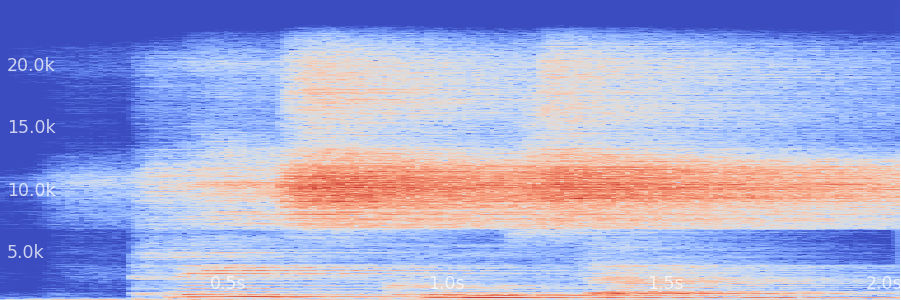
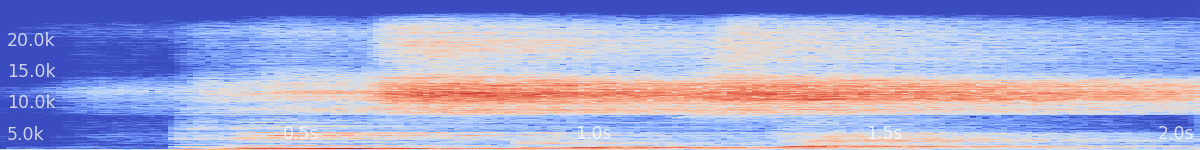

  0%|                                                  | 0/500 [00:00<?, ?it/s]


IndexError: tuple index out of range

In [61]:
# Initialize our starting parameters
params = torch.nn.parameter.Parameter(torch.randn(signal.batch_size, channel.num_params).to(device))
optimizer = torch.optim.Adam([params], lr=1e-2)

# Play our starting audio
print("Starting audio - applied untrained parameters of just channel of just EQ ")
channel(signal.clone().to(device), torch.sigmoid(params)).clone().detach().cpu().widget()

# Optimize our parameters by matching effected audio against the target audio
n_iters = 500
pbar = tqdm(range(n_iters), total=n_iters)
for n in pbar:
    
    # Apply effect with out estimated parameters
    # signal_effected = channel(signal, torch.sigmoid(params))
    signal_effected = channel(signal.to(device), torch.sigmoid(params.to(device)))

    x_signal_effected = signal_effected.audio_data.mean(1)

    # Get CLAP embedding for effected audio
    embedding_effected = clap_model._get_audio_embeddings(x_signal_effected) #.get_audio_embeddings takes in preprocessed audio

    # Compute distance between our effected audio embedding vector and the target text 
    # embedding vector. We use cosine distance (essentially the negative dot product
    # between vectors). When two vectors are "aligned" (pointing in the same direction), 
    # their dot product will be high. We thus penalize a small dot product to try to
    # bring our audio vector "into alignment" with the text vector.
    loss = -(embedding_effected @ embedding_target.T).sum()

    # Optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    pbar.set_description(f"step: {n+1}/{n_iters}, loss: {loss.item():.3f}")

# Play final signal with optimized effects parameters
print("Final audio")
channel(signal.clone().to(device), torch.sigmoid(params)).clone().detach().cpu().widget()

In [ ]:
#scrap from old clap
channel = Channel(
    dasp_pytorch.ParametricEQ(sample_rate=SAMPLE_RATE),
)

# Use GPU if available
device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
signal = signal.to(device)
model = model.to(device)

# Our target is a CLAP embedding, and we'll perform matching in the embedding space rather than 
# the audio space
text_target = "bright"
embedding_target = clap_embed_text(text_target, model).detach()

# Initialize our starting parameters
params = torch.nn.parameter.Parameter(torch.randn(signal.batch_size, channel.num_params).to(device))
optimizer = torch.optim.Adam([params], lr=1e-2)

# Play our starting audio
print("Starting audio - applied untrained parameters of just channel of just EQ ")
channel(signal.clone().to(device), torch.sigmoid(params)).clone().detach().cpu().widget()

# Optimize our parameters by matching effected audio against the target audio
n_iters = 500
pbar = tqdm(range(n_iters), total=n_iters)
for n in pbar:
    
    # Apply effect with out estimated parameters
    signal_effected = channel(signal, torch.sigmoid(params))

    # Get CLAP embedding for effected audio
    embedding_effected = clap_embed_audio(signal_effected, model, quantize=False)

    # Compute distance between our effected audio embedding vector and the target text 
    # embedding vector. We use cosine distance (essentially the negative dot product
    # between vectors). When two vectors are "aligned" (pointing in the same direction), 
    # their dot product will be high. We thus penalize a small dot product to try to
    # bring our audio vector "into alignment" with the text vector.
    loss = -(embedding_effected @ embedding_target.T).sum()

    # Optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    pbar.set_description(f"step: {n+1}/{n_iters}, loss: {loss.item():.3f}")

# Play final signal with optimized effects parameters
print("Final audio")
channel(signal.clone().to(device), torch.sigmoid(params)).clone().detach().cpu().widget()